# DA example after initaliastion

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

In [6]:
def imshow3(etahuhv, negative_vlim=True,  eta_vlim=0.05, huv_vlim=2, cmap="coolwarm", title=None):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    fig.suptitle(title, y=0.85)

    im = axs[0].imshow(etahuhv[0], vmin=-negative_vlim*eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [7]:
def imshow3var(est_var, eta_vlim=0.00025, huv_lim=1.0):
    return imshow3(est_var, negative_vlim=False, eta_vlim=eta_vlim, huv_vlim=huv_lim, cmap="Reds")

In [8]:
def imshowSim(sim, eta_vlim=0.05, huv_lim=2.0):
    eta, hu, hv = sim.download(interior_domain_only=False)
    return imshow3(np.array([eta, hu, hv]), eta_vlim=eta_vlim, huv_vlim=huv_lim)

### Perturbing initial conditions

In [9]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [10]:
ls = [6, 7, 8, 9, 10]

In [11]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [12]:
init_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.05,
}

In [13]:
sim_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 7,
    "basis_y_start": 2,
    "basis_y_end": 8,

    "kl_decay": 1.25,
    "kl_scaling": 0.0025,
}


### Ensemble

In [14]:
read_path = "/home/florianb/havvarsel/multilevelDA/scripts/VarianceLevels/Basin/2023-05-05T14_03_12"

vars = np.load(read_path+"/vars_43200.npy")
diff_vars = np.load(read_path+"/diff_vars_43200.npy")

In [15]:
from utils.BasinAnalysis import *
analysis = Analysis(ls, vars, diff_vars, args_list)

In [46]:
ML_Nes = analysis.optimal_Ne(tau=1e-4)#5e-5)
ML_Nes

array([2397,  310,   61,   11,    5], dtype=int32)

### Ensemble

In [17]:
from utils.BasinEnsembleInit import *

In [18]:
ML_ensemble = initMLensemble(ML_Nes, args_list, make_init_steady_state, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
1
2
3
4


In [19]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [20]:
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [21]:
prior_ensemble = MLOceanEnsemble.download()

### Statistics

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

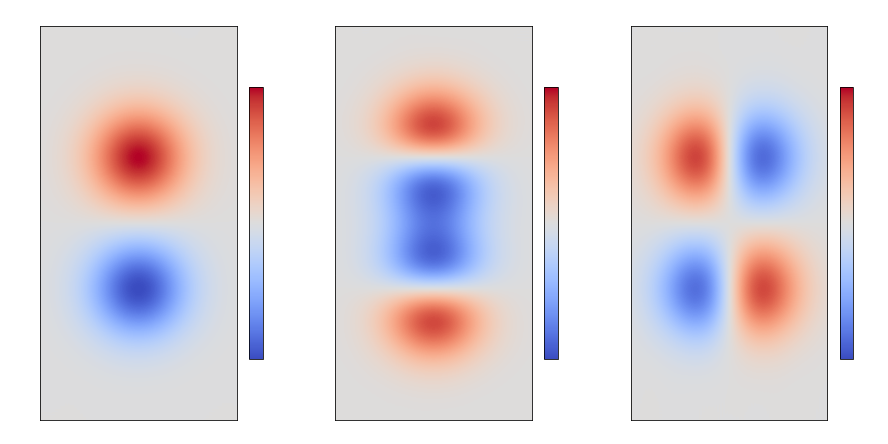

In [22]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=1, huv_vlim=25)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

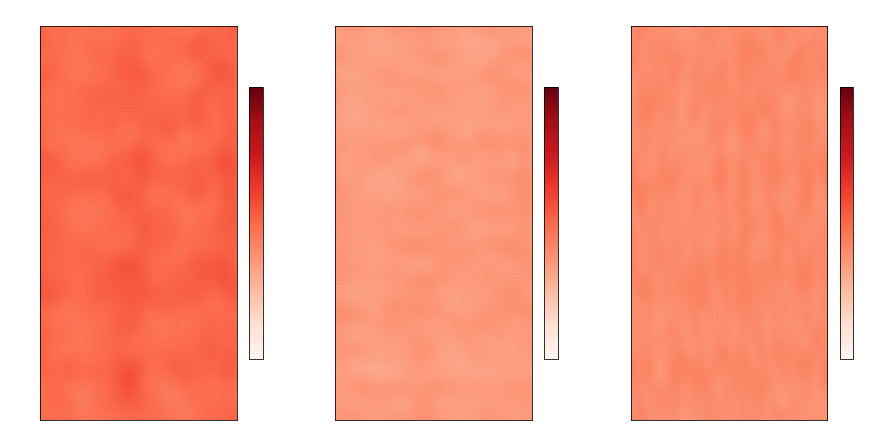

In [23]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=1e-3, huv_lim=5)

### Truth

In [24]:
from utils.BasinInit import *

In [25]:
data_args = make_init_steady_state(args_list[-1])

In [26]:
truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args)
mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args)
mekl.perturbSim(truth)

In [27]:
Hx, Hy = 500, 1000

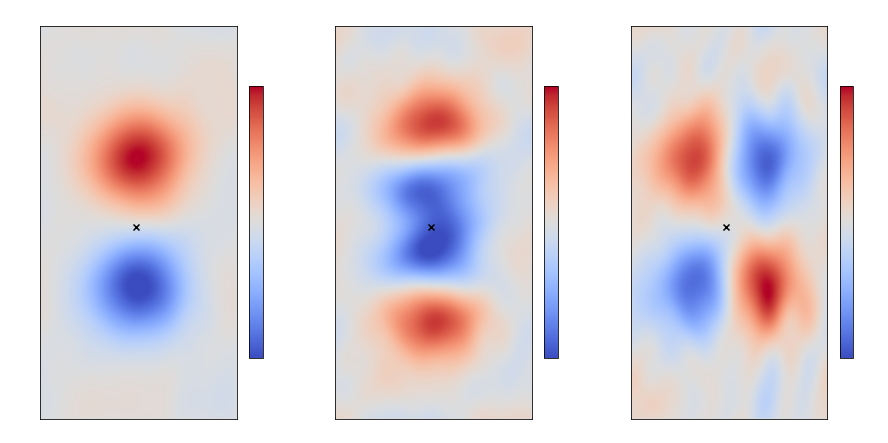

In [28]:
fig, axs = imshowSim(truth, eta_vlim=1, huv_lim=25)

for i in range(3):
    axs[i].scatter(Hx, Hy, marker="x", c="black")

In [29]:
R = [5e-3, 5e-1, 5e-1]

In [30]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

print([true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]])
print(obs)

[-0.045331676, -23.182543, -0.42635238]
[-4.10527363e-02 -2.38902071e+01 -2.32948050e-02]


### Conditioning after initial noise

In [31]:
from gpuocean.dataassimilation import MLEnKFOcean

In [32]:
from importlib import reload
reload(MLEnKFOcean)

<module 'gpuocean.dataassimilation.MLEnKFOcean' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/dataassimilation/MLEnKFOcean.py'>

In [33]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

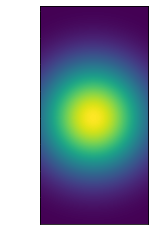

In [34]:
r = 5e4
plt.imshow( MLEnKF.GCweights(MLEnKF.X[0,Hx], MLEnKF.Y[Hy,0], r) )

In [35]:
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, Hx, Hy, R, r = 5*1e7, obs_var=slice(1,3), relax_factor = 1.0, min_localisation_level=0)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

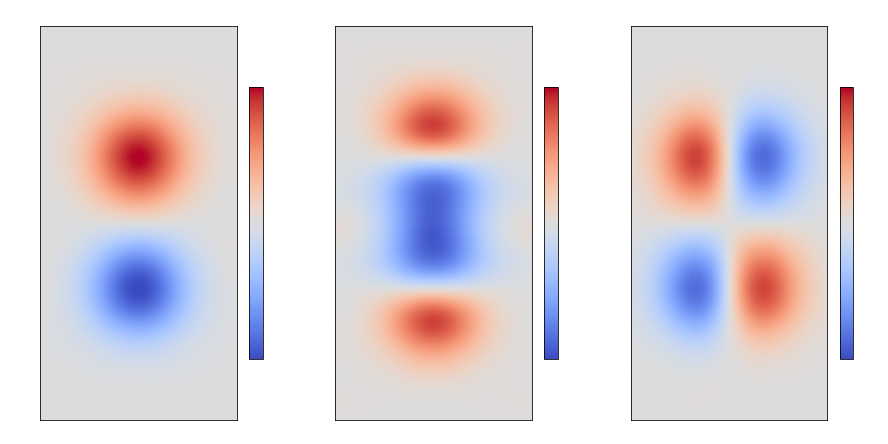

In [36]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=1, huv_vlim=25)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

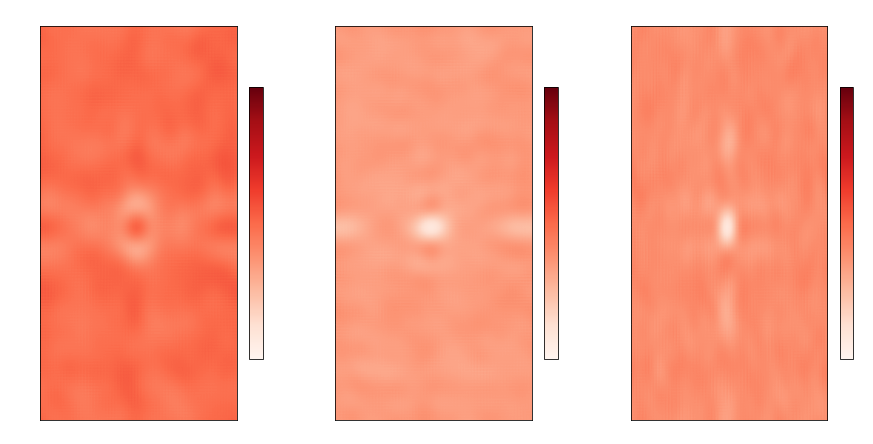

In [37]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=1e-3, huv_lim=5)

In [38]:
freq = 50
Hxs = np.arange( 512, 1024, freq)
Hys = np.arange(1024, 2048, 2*freq)

In [39]:
MLOceanEnsemble.rank(truth, [z for z in zip(Hxs, Hys)])

[array([0.8749739 , 0.55149781, 0.65029136]),
 array([0.98229578, 0.67422174, 0.91665119]),
 array([0.83861433, 0.90016899, 0.46384227]),
 array([0.63612695, 0.24423483, 0.36306539]),
 array([0.64698167, 0.43593764, 0.45663094]),
 array([0.75138099, 0.4900367 , 0.72180765]),
 array([0.83968805, 0.53255347, 0.02312465]),
 array([0.95555466, 0.08360181, 0.75053969]),
 array([0.99165624, 0.77366062, 0.37431491]),
 array([0.8837307 , 0.99123905, 0.34423951]),
 array([0.07957124, 0.9062937 , 0.93876684])]

### Data Assimilation Step

In [40]:
truth.setKLModelError(**sim_model_error_basis_args)
truth.model_time_step = 60.0

truth.dataAssimilationStep(300)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

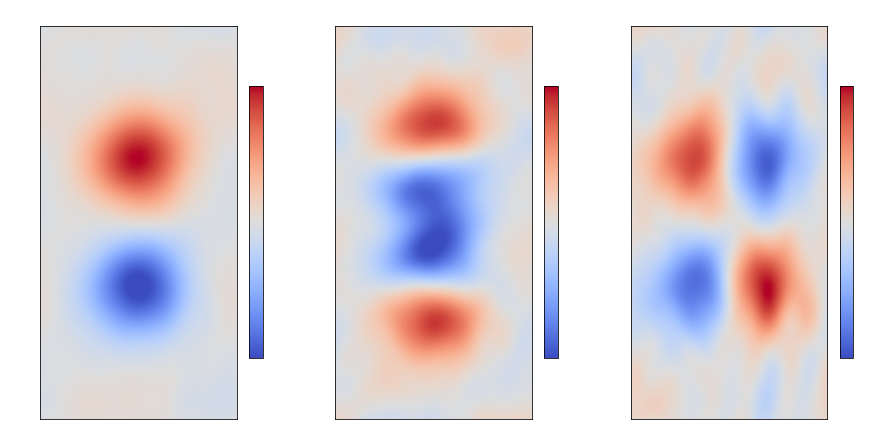

In [48]:
imshowSim(truth, eta_vlim=1, huv_lim=25)

In [42]:
for e in range(MLOceanEnsemble.Nes[0]):
    MLOceanEnsemble.ML_ensemble[0][e].dataAssimilationStep(300)

for l_idx in range(1, MLOceanEnsemble.numLevels):
    for e in range(MLOceanEnsemble.Nes[l_idx]):
        MLOceanEnsemble.ML_ensemble[l_idx][0][e].dataAssimilationStep(300, otherSim=MLOceanEnsemble.ML_ensemble[l_idx][1][e])

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

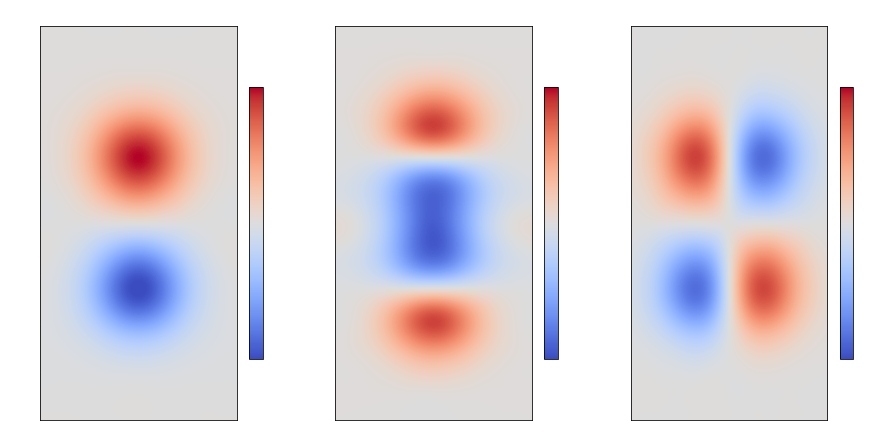

In [43]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=1, huv_vlim=25)